## **Introducción**

Este práctico consiste en entrenar un perceptrón multicapa como regresor aplicado al dataset de housing usado en la unidad anterior. La idea es explorar la versatilidad de los modelos neuronales, y compararlos con los modelos vistos previamente, como para ver si logramos un mejor desempeño en las estimaciones.

## **Objetivo general**

Aprender a construir y entrenar un modelo neuronal utilizando `scikit-learn`.

## **Objetivos específicos**

*   Consturir un regresor de tipo perceptrón multicapa.
*   Entrenarlo para realizar estimaciones de precio de venta sobre el dataset de housing utilizado en la Unidad 1.
*   Estudiar la evolución del modelo a medida que es entrenado.
*   Comprender el significado de los principales hiperparámetros y variarlos para mejorar los resultados.



## **Configuración general**

In [1]:
## Librerías generales
import numpy as np
import pandas as pd
from pandas.api.types import is_numeric_dtype

## Filtramos advertencias relacionadas con la convergencia de los algoritmos
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore', category=ConvergenceWarning)

## Clases y funciones útiles de scikit-learn
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, median_absolute_error

## Modelo neuronal:
## Multi-Layer Perceptron
from sklearn.neural_network import MLPRegressor

## Otros modelos para comparar con el modelo neuronal
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

## Barras de progreso en los iteradores
from tqdm.notebook import tqdm

## Herramientas para graficar
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_context('talk')

### **Funciones útiles**

In [2]:
## Utilizaremos la raiz cuadrada del error cuadrático medio como 
## medida del error
def rmse(y1, y2):
    """
    Raiz cuadrada del error cuadrático medio.
    """
    return np.sqrt(mean_squared_error(y1, y2))

## **Preprocesamiento básico del dataset**

Para aplicar cualquier modelo de aprendizaje automático debemos transformar nuestros datos en una matriz numérica. Esto implica, entre otras cosas, impugnar o descartar datos faltantes, codificar variables categóricas, etc.

In [3]:
TARGET_COL = 'SalePrice'     ## Precio de venta

## Columnas categóricas
ordinal_cols = [
    'LotShape', 'Utilities', 'LandSlope', 'OverallQual', 'OverallCond',
    'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
    'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
    'HeatingQC', 'Electrical', 'KitchenQual', 'Functional',
    'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 
    'PavedDrive', 'PoolQC', 'Fence'
]
nominal_cols = [
    'MSSubClass', 'MSZoning', 'Street', 'Alley', 
    'LandContour', 'LotConfig', 'Neighborhood',
    'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 
    'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 
    'MasVnrType', 'Foundation', 'Heating', 'CentralAir', 
    'GarageType', 'MiscFeature', 'SaleType', 'SaleCondition'
    
]
categorical_cols = ordinal_cols + nominal_cols

## Collumnas numéricas
continuous_cols = [
    'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
    'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 
    'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 
    '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal'
]
discrete_cols = [
    'YearBuilt', 'YearRemod/Add', 'BsmtFullBath', 'BsmtHalfBath', 
    'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
    'Fireplaces', 'GarageYrBlt', 'GarageCars', 'MoSold', 'YrSold'
]
numeric_cols = continuous_cols + discrete_cols


def preprocess(df):
    """
    Preprocesamiento básico. Toma el dataset original y devuelve un dataset
    apto para modelos de aprendizaje automático, donde todas las variables
    tienen valores numéricos no nulos.
    """
    ## Descartamos filas sin datos
    df = df.dropna(how='all')

    ## Descartamos filas sin precio de venta
    df = df.dropna(subset=[TARGET_COL])

    ## Eliminamos columnas innecesarias
    cols_to_drop = ['Order', 'PID']
    df = df.drop(columns=cols_to_drop)
    
    ## Impugnamos valores nulos en las variables categóricas, reemplazándolos
    ## por la moda
    for col in categorical_cols:
        df[col] = df[col].fillna(df[col].mode().values[0])

    ## Impugnamos valores nulos en las variables numéricas, reemplazándolos
    ## por la mediana
    for col in numeric_cols:
        df[col] = df[col].fillna(df[col].median())

    ## Codificamos las variables categóricas
    le = LabelEncoder()
    for col in categorical_cols:
        df[col] = le.fit_transform(df[col])

    ## Verificamos que no existan valores nulos en el dataset final
    assert df.isna().any().any() == False

    ## Verificamos que todas las columnas son variables numéricas
    assert np.all(is_numeric_dtype(df[col]) for col in df.columns)

    return df

In [4]:
# Leemos el dataset
path = 'https://drive.google.com/uc?export=download&id=1UVZnskEk-GZbTo4uW2usL7ze92XVDS8_'
df = pd.read_csv(path)

df = preprocess(df)
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemod/Add,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,0,5,141.0,31770,1,0,0,3,0,0,0,15,2,2,0,2,5,4,1960,1960,3,1,3,10,4,112.0,3,4,1,4,2,1,1,639.0,5,0.0,441.0,1080.0,1,1,1,4,1656,0,0,1656,1.0,0.0,1,0,3,1,4,7,7,2,2,1,1960.0,0,2.0,528.0,4,4,1,210,62,0,0,0,0,0,2,3,0,5,2010,9,4,215000
1,0,4,80.0,11622,1,0,3,3,0,4,0,15,1,2,0,2,4,5,1961,1961,1,1,13,14,3,0.0,3,4,1,4,4,3,4,468.0,3,144.0,270.0,882.0,1,4,1,4,896,0,0,896,0.0,0.0,1,0,2,1,4,5,7,0,2,1,1961.0,2,1.0,730.0,4,4,2,140,0,0,0,120,0,0,2,3,0,6,2010,9,4,105000
2,0,5,81.0,14267,1,0,0,3,0,0,0,15,2,2,0,2,5,5,1958,1958,3,1,14,15,1,108.0,3,4,1,4,4,3,0,923.0,5,0.0,406.0,1329.0,1,4,1,4,1329,0,0,1329,0.0,0.0,1,1,3,1,2,6,7,0,2,1,1958.0,2,1.0,312.0,4,4,2,393,36,0,0,0,0,0,2,1,12500,6,2010,9,4,172000
3,0,5,93.0,11160,1,0,3,3,0,0,0,15,2,2,0,2,6,4,1968,1968,3,1,3,3,3,0.0,2,4,1,4,4,3,0,1065.0,5,0.0,1045.0,2110.0,1,0,1,4,2110,0,0,2110,1.0,0.0,2,1,3,1,0,8,7,2,4,1,1968.0,0,2.0,522.0,4,4,2,0,0,0,0,0,0,0,2,3,0,4,2010,9,4,244000
4,5,5,74.0,13830,1,0,0,3,0,4,0,8,2,2,0,5,4,4,1997,1998,1,1,13,14,3,0.0,3,4,2,2,4,3,2,791.0,5,0.0,137.0,928.0,1,2,1,4,928,701,0,1629,0.0,0.0,2,1,3,1,4,6,7,1,4,1,1997.0,0,2.0,482.0,4,4,2,212,34,0,0,0,0,0,2,3,0,3,2010,9,4,189900


### **Definición de features y variable objetivo**

Definimos las variables de características (features) y la variable objetivo (target)

In [5]:
## Utilizamos como predictoras todas las variables, 
## excepto la variable objetivo
X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]

Observamos cómo está distribuida la variable objetivo

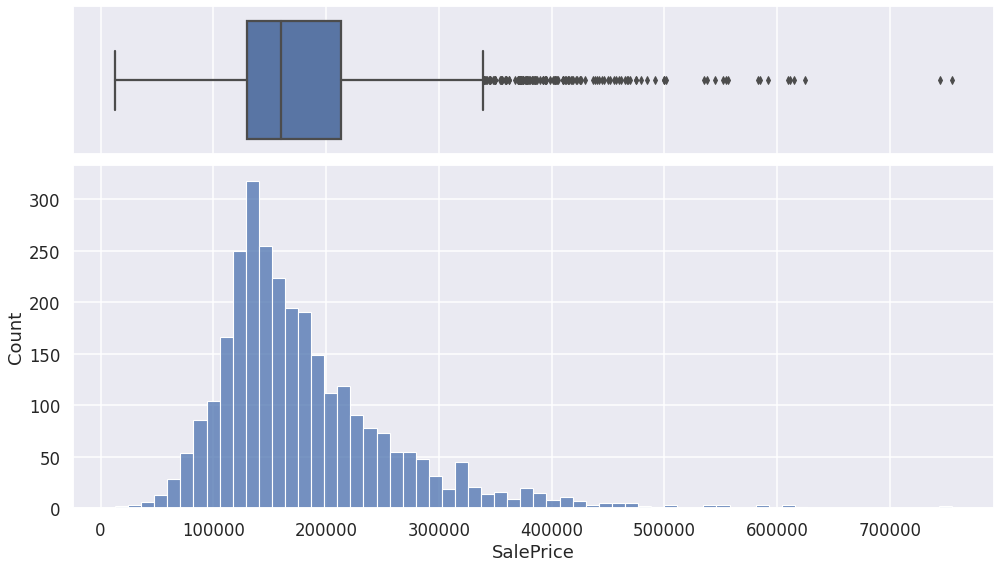

In [6]:
fig, axes = plt.subplots(
    figsize=(14, 8), nrows=2, sharex=True, 
    gridspec_kw={"height_ratios": (.3, .7)}
)
sns.boxplot(data=df, x=TARGET_COL, ax=axes[0])
sns.histplot(data=df, x=TARGET_COL, ax=axes[1])
axes[0].set_xlabel('')
plt.tight_layout()

### **Separación entrenamiento / evaluación**

Dividimos el dataset en un conjunto de entrenamiento y uno de evaluación. Por simplicidad, no utilizaremos conjunto de validación, sino que validaremos nuestro modelo directamente sobre el conjunto de evaluación.

In [7]:
test_size = 0.20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=22)

## **Modelos de referencia**

Construimos algunos modelos relativamente sencillos como para que nos sirvan de referencia y tengamos con qué comparar nuestros modelos neuronales.

### **Regresor *dummy***

Definimos un estimador "tonto" o *dummy*. Este estimador calcula una medida de centralidad para la variable objetivo sobre los datos de entrenamiento y devuelve siempre ese valor, independientemente del ejemplo que se le presente.

In [8]:
dummyModel = DummyRegressor(strategy='median')
dummyModel.fit(X_train, y_train)
pred_train = dummyModel.predict(X_train)
pred_test = dummyModel.predict(X_test)
print('Train RMSE = {:.0f}'.format(rmse(pred_train, y_train)))
print('Test  RMSE = {:.0f}'.format(rmse(pred_test, y_test)))

Train RMSE = 83377
Test  RMSE = 76538


### **Modelo de regresión lineal**

Vemos si una regresión lineal mejora nuestro modelo de base

In [9]:
# Instanciamos una clase LinearRegression
linearRegression = LinearRegression()
linearRegression.fit(X_train, y_train)
pred_train = linearRegression.predict(X_train)
pred_test = linearRegression.predict(X_test)
print('Train RMSE = {:.0f}'.format(rmse(pred_train, y_train)))
print('Test  RMSE = {:.0f}'.format(rmse(pred_test, y_test)))

Train RMSE = 29191
Test  RMSE = 29815


### **Modelo basado en árboles de decisión**

Entrenamos un modelo basado en árboles de decisión, particularmente Random Forest, para ver si logramos mejorar el modelo de regresión lineal

In [10]:
randomForestRegressor = RandomForestRegressor(random_state=22, n_jobs=-1)
randomForestRegressor.fit(X_train, y_train)
pred_train = randomForestRegressor.predict(X_train)
pred_test = randomForestRegressor.predict(X_test)
print('Train RMSE = {:.0f}'.format(rmse(pred_train, y_train)))
print('Test  RMSE = {:.0f}'.format(rmse(pred_test, y_test)))

Train RMSE = 9837
Test  RMSE = 24283


Además de comparar el error, comparamos los residuos de cada modelo

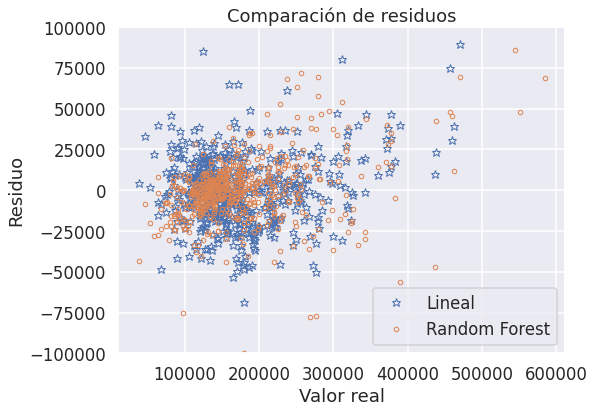

In [11]:
models = [linearRegression, randomForestRegressor]
labels = ['Lineal', 'Random Forest']
markers = ['*', '.']
fig, ax = plt.subplots(figsize=(8,6))
for i, model in enumerate(models):
    pred_test = model.predict(X_test)
    ax.plot(
        y_test, y_test - pred_test, 
        markers[i], fillstyle='none', label=labels[i]
    )
ax.set_title('Comparación de residuos')
ax.set_ylim(-100000, 100000)
ax.set_xlabel('Valor real')
ax.set_ylabel('Residuo')
ax.legend()
plt.show()

## **Modelos de Redes Neuronales**

### Perceptrón multicapa

Vamos a utilizar la clase ``MLPRegressor`` de ``scikit-learn``.

Algunos de los parámetros más relevantes de esta clase son

- **hidden_layer_sizes:** Cantidad y tamaño de las capas ocultas
- **activation:** función de activación
- **solver:** algoritmo para optimizar los pesos
- **learning_rate:** protocolo de aprendizaje
- **learning_rate_init:** valor inicial de la tasa de aprendizaje
- **max_iter:** cantidad máxima de iteraciones (épocas) a realizar
- **alpha**: término de regularización (penalización L2)

La función de costo con la que trabaja el modelo es

$$
\text{Loss}(y, \hat{y}, W) = \dfrac{1}{2} ||y-\hat{y}||_2^2 + \dfrac{\alpha}{2} ||W||_2^2,
$$

donde $y$ son los valores reales, $\hat{y}$ las predicciones, $W$ es la matriz de pesos y $\alpha$ es el parámetro de regularización.

### **Primera prueba**

Veamos primero cómo se desempeña el modelo con los parámetros por default. Sólo determinamos la semilla del generador de números aleatorios para garantizar la reproducibilidad.

In [12]:
mlp = MLPRegressor(random_state=22)
mlp.fit(X_train, y_train)

pred_train = mlp.predict(X_train)
pred_test  = mlp.predict(X_test)

print('Train RMSE = {:.0f}'.format(rmse(pred_train, y_train)))
print('Test  RMSE = {:.0f}'.format(rmse(pred_test, y_test)))

Train RMSE = 41426
Test  RMSE = 40614


Vemos que el modelo neuronal supera el modelo base, pero es significativamente peor que el modelo lineal.

### **Segunda prueba**

Por lo general, las redes neuronales son sensibles ante los cambios de escala (o de unidades). Por eso, suele ser conveniente escalar los datos antes de entrenar el modelo.

Entrenamos el mismo modelo que antes pero ahora sobre datos escalados.

In [13]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()

## Aplicamos la transformación de escala sobre los features
scaler_X.fit(X_train)
X_scaled_train = scaler_X.transform(X_train)
X_scaled_test  = scaler_X.transform(X_test)

## Aplicamos la transformación de escala sobre la variable objetivo
## Observación: StandardScaler toma como input una matriz. Si queremos darle un
## vector (como por ej. para utilizar con la variable objetivo), tenemos que 
## transformar ese vector en una matriz de una sola columna. Esto lo hacemos
## con el método 'reshape'
scaler_y.fit(y_train.values.reshape(-1, 1))
y_scaled_train = scaler_y.transform(y_train.values.reshape(-1, 1))[:,0]
y_scaled_test  = scaler_y.transform(y_test.values.reshape(-1, 1))[:,0]

In [14]:
mlp = MLPRegressor(random_state=22)
mlp.fit(X_scaled_train, y_scaled_train)

## Un modelo alimentado con datos escalados devuelve predicciones también
## escaladas
pred_scaled_train = mlp.predict(X_scaled_train)
pred_scaled_test  = mlp.predict(X_scaled_test)

## Para evaluar las predicciones, debemos aplicr la transformación de escala 
## inversa
pred_train = scaler_y.inverse_transform(pred_scaled_train)
pred_test  = scaler_y.inverse_transform(pred_scaled_test)

print('Train RMSE:', rmse(pred_train, y_train))
print('Test RMSE:', rmse(pred_test, y_test))

Train RMSE: 7059.34101728475
Test RMSE: 35403.78194844932


Vemos que el modelo mejora bastante para el conjunto de entrenamiento. Para el conjunto de evaluación hay también una mejoría, aunque no tan marcada.

### **Evolución del modelo**

Ahora veamos más en detalle cómo el modelo va evolucionando en el tiempo, graficando el RMSE en función del número de épocas (cantidad de iteraciones). Para ello, vamos a definir el modelo utilizando el argumento `warm_start = True`. Este argumento hace que cada vez que llamemos al método `.fit`, en lugar de comenzar nuevamente "desde cero", comience con los últimos valores de los parámetros.

In [15]:
## Cantidad de épocas
n_epochs = 200
epochs = range(1, n_epochs+1)

## Listas donde almacenaremos las métricas de error
train_rmse_values = []
test_rmse_values = []

## Diccionario de hiperparámetros del modelo
hyperparams = dict(
    solver='adam',
    alpha=0.001,
    hidden_layer_sizes=(100,),
    learning_rate_init=0.01,
    learning_rate='constant',
    momentum=0.9
)
#
model = MLPRegressor(
    random_state=22, 
    max_iter=1, 
    warm_start=True,
    **hyperparams
)

def get_number_of_params(model):
    """
    Devuelve el número de parámetros de un modelo de tipo 
    Multi-Layer Perceptron
    """
    return sum(
        [layer_coefs.size for layer_coefs in model.coefs_] + 
        [layer_bias.size for layer_bias in model.intercepts_]
    )

#### Entrenamiento

In [16]:
for epoch in tqdm(range(n_epochs)):
    ## Fiteo del modelo
    model.fit(X_scaled_train, y_scaled_train)
    
    ## Predicciones sobre conjunto de entrenamiento y evaluación
    pred_train = scaler_y.inverse_transform(model.predict(X_scaled_train))
    pred_test  = scaler_y.inverse_transform(model.predict(X_scaled_test))
    
    ## Calculamos el error en los conjuntos de entrenamiento y evaluación
    train_rmse_values.append(rmse(pred_train, y_train))
    test_rmse_values.append(rmse(pred_test, y_test))

epochs = range(1, len(train_rmse_values)+1)
print('Cantidad de parámetros:', get_number_of_params(model))
print('Cantidad de muestras de entrenamiento:', X_scaled_train.shape[0])

  0%|          | 0/200 [00:00<?, ?it/s]

Cantidad de parámetros: 8101
Cantidad de muestras de entrenamiento: 2344


#### Evaluación

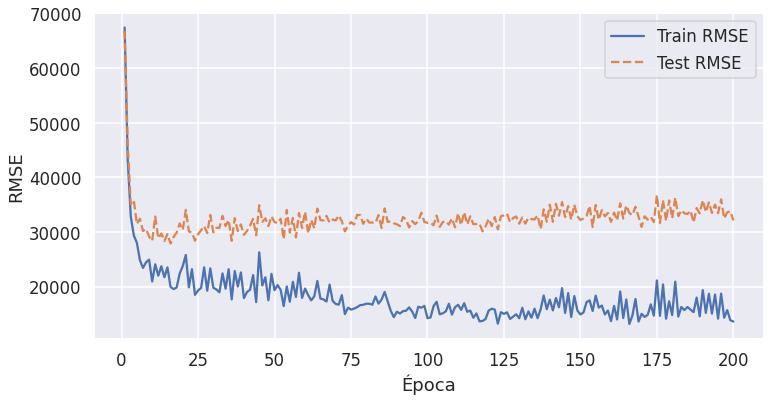

In [17]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_xlabel('Época')
ax.set_ylabel('RMSE')
ax.plot(epochs, train_rmse_values, label='Train RMSE')
ax.plot(epochs, test_rmse_values, linestyle='--', label='Test RMSE')
ax.legend()
plt.show()

### **Ajuste de hiperparámetros**

In [18]:
n_epochs = 1000
epochs = range(1, n_epochs+1)

learning_rate_init_values = [
    0.00001, 0.0001, 0.001
]

metrics = {}

for learning_rate_init in tqdm(learning_rate_init_values):
    hyperparams = dict(
        solver='adam',
        alpha=0.001,
        hidden_layer_sizes=(100, ),
        learning_rate_init=learning_rate_init
    )
    model = MLPRegressor(
        random_state=12, 
        max_iter=1, 
        warm_start=True,
        **hyperparams
    )

    train_rmse_values = []
    test_rmse_values = []

    for epoch in tqdm(epochs, leave=False):
        ## Fiteo del model
        model.fit(X_scaled_train, y_scaled_train)

        ## Predicciones sobre conjunto de entrenamiento y validacion
        pred_train = scaler_y.inverse_transform(model.predict(X_scaled_train))
        pred_test  = scaler_y.inverse_transform(model.predict(X_scaled_test))

        ## Cálculo de métricas
        train_rmse_values.append(rmse(pred_train, y_train))
        test_rmse_values.append(rmse(pred_test, y_test))
        
    metrics[learning_rate_init] = pd.DataFrame({
        'train_rmse': train_rmse_values,
        'test_rmse': test_rmse_values
    })

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

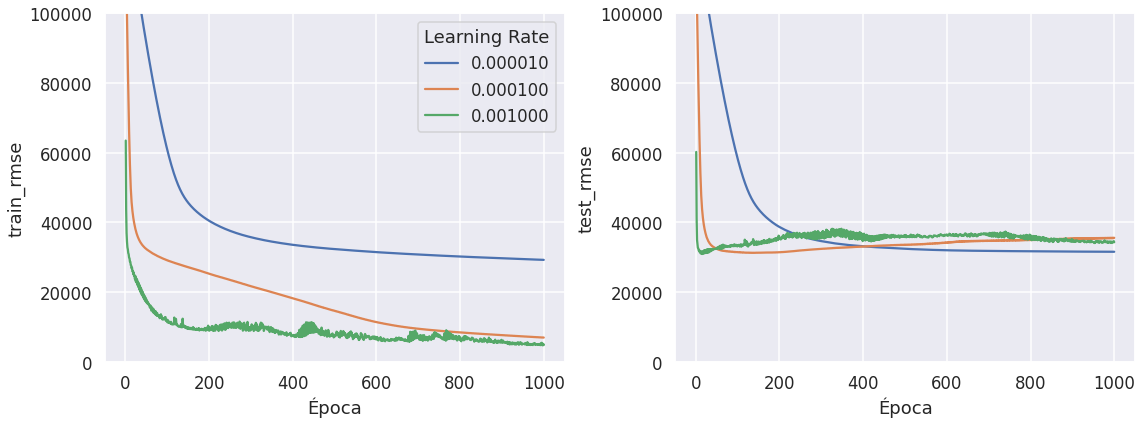

In [19]:
fig, axes = plt.subplots(figsize=(16, 6), ncols=2)

for hyperparm_value, hyperparm_metrics in metrics.items():
    for j, (metric_name, metric_values) in enumerate(hyperparm_metrics.items()):
        ax = axes[j]
        ax.set_ylabel(metric_name)
        x_plot = epochs
        y_plot = metric_values
        ax.plot(x_plot, y_plot, label=f'{hyperparm_value:f}')

for ax in axes:
    ax.set_xlabel('Época')

legend = axes[0].legend()
legend.set_title('Learning Rate')

for ax in axes:
    pass
    ax.set_ylim(0, 100000)

plt.tight_layout()
plt.show()

## **Tareas**

1.   **Importancia de escalar los datos.** Repetir el gráfico de RMSE para el conjunto de entrenamiento y evaluación en función del número de épocas para un modelo igual al del ejemplo, pero sin escalar los datos. Comparar el desempeño (mejor valor de RMSE para evaluación) y convergencia (número de épocas hasta estabilizar el error). 

2.   **Análisis de arquitectura.** Proponer variaciones en la arquitectura de la red (cantidad de capas y cantidad de neuronas por capa). ¿Cómo afecta la profundidad de la red al desempeño del modelo? ¿Y al tiempo de cómputo?

3. **Ajuste de hiperparámetros.** Elegir dos hiperparámetros y variarlos hasta encontrar la mejor combinación. 

